# Base

## Configuration

In [1]:
INPUT_FILE = 'csvs/database_regression.csv'
HOPT_ELM_EXP = 'base_elm_1l_cv'
HOPT_SVM_EXP = 'base_svm_cv'

In [2]:
from lib.helpers import *
from lib.plots import *
from IPython.display import set_matplotlib_formats
from IPython.core.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2
set_matplotlib_formats('retina', 'png', 'pdf')

## Read data

In [3]:
import pandas as pd

df = pd.read_csv(INPUT_FILE, na_values=['#NAME?'])

In [4]:
len(df)

22674

In [5]:
df.head(5)

,timestamp,power,power_0,power_6,power_12,power_18
0,817102800.0,17.368866,NaN,NaN,NaN,NaN
1,817124400.0,0.000000,NaN,NaN,NaN,NaN
2,817146000.0,0.000000,17.368866,NaN,NaN,NaN
3,817167600.0,1.750994,0.000000,17.368866,NaN,NaN
4,817189200.0,13.754562,0.000000,0.000000,17.368866,NaN


### Date conversion

In [6]:
def to_datetime(row):
    row = pd.to_datetime(row, unit='s')
    row = row.dt.tz_localize('UTC').dt.tz_convert('Europe/Brussels')
    row = row.apply(lambda x: x.strftime('%d/%m/%Y %H:%M:%S'))
    
    return row

df['timestamp'] = to_datetime(df['timestamp'])

In [7]:
df.head(5)

,timestamp,power,power_0,power_6,power_12,power_18
0,23/11/1995 06:00:00,17.368866,NaN,NaN,NaN,NaN
1,23/11/1995 12:00:00,0.000000,NaN,NaN,NaN,NaN
2,23/11/1995 18:00:00,0.000000,17.368866,NaN,NaN,NaN
3,24/11/1995 00:00:00,1.750994,0.000000,17.368866,NaN,NaN
4,24/11/1995 06:00:00,13.754562,0.000000,0.000000,17.368866,NaN


### Remove missing data

In [8]:
df.isnull().sum()

timestamp      0
power          0
power_0      178
power_6      197
power_12     207
power_18     247
dtype: int64

In [9]:
df.dropna(axis=0, how='any', inplace=True)

len(df)

22162

## Data Distribution

### Distribution of features

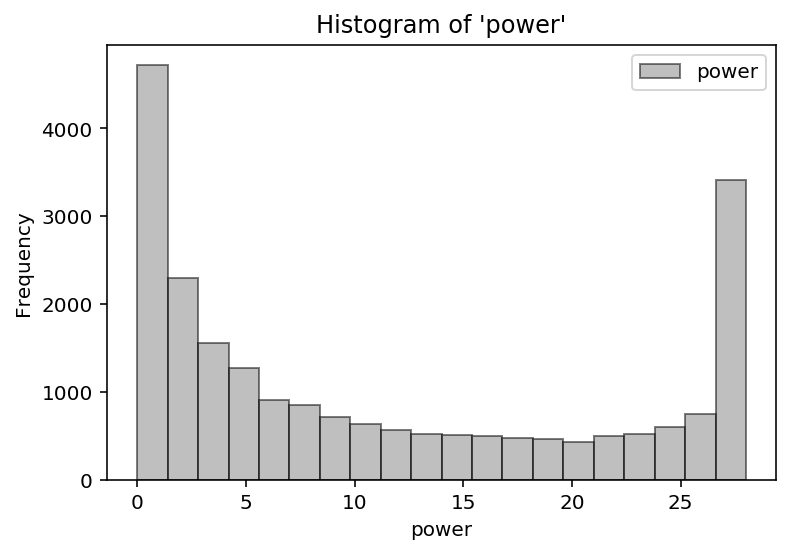

In [10]:
plot_histogram(df['power'])

## Data Preparation

In [11]:
y = df.power
X = df.drop(['timestamp', 'power'], 1)

In [12]:
y.head(5)

5    23.681535
6    14.933800
7    12.019518
8    14.674929
9    16.848430
Name: power, dtype: float64

In [13]:
X.head(5)

,power_0,power_6,power_12,power_18
5,1.750994,0.000000,0.000000,17.368866
6,13.754562,1.750994,0.000000,0.000000
7,23.681535,13.754562,1.750994,0.000000
8,14.933800,23.681535,13.754562,1.750994
9,12.019518,14.933800,23.681535,13.754562


## Feature Engineering

### Interaction amongst features

In [14]:
X = add_interactions(X)
X.head(5)

,power_0,power_6,power_12,power_18,power_0_power_6,power_0_power_12,power_0_power_18,power_6_power_12,power_6_power_18,power_12_power_18
0,1.750994,0.000000,0.000000,17.368866,0.000000,0.000000,30.412775,0.000000,0.000000,0.000000
1,13.754562,1.750994,0.000000,0.000000,24.084152,0.000000,0.000000,0.000000,0.000000,0.000000
2,23.681535,13.754562,1.750994,0.000000,325.729153,41.466220,0.000000,24.084152,0.000000,0.000000
3,14.933800,23.681535,13.754562,1.750994,353.655304,205.407879,26.148990,325.729153,41.466220,24.084152
4,12.019518,14.933800,23.681535,13.754562,179.497068,284.640629,165.323204,353.655304,205.407879,325.729153


## Feature selection and model building

### Split processed data

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=0)

In [16]:
print('Train: {}'.format(X_train.shape))
print('Test: {}'.format(X_test.shape))

Train: (16621, 10)
Test: (5541, 10)


### Shuffle train data

In [17]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=0)

### Feature selection

In [18]:
from sklearn.feature_selection import mutual_info_regression

feature_scores = get_feature_values(X, y)
pd.Series(feature_scores, index=X.columns).sort_values(ascending=False).head(20)

power_0              0.090324
power_0_power_6      0.085174
power_0_power_12     0.080399
power_0_power_18     0.059195
power_6_power_12     0.057025
power_6              0.056759
power_12             0.044663
power_6_power_18     0.043699
power_12_power_18    0.031845
power_18             0.018798
dtype: float64

In [19]:
len(feature_scores)

10

## Parameter exploration

In [20]:
from datetime import datetime
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics.scorer import make_scorer

cv = ShuffleSplit(n_splits=6)
scoring = {
    'ev': make_scorer(explained_variance_score),
    'r2': make_scorer(r2_score),
    'rmse': make_scorer(rmse_score, greater_is_better=False),
}
models = {}

### Find hyperparameters

In [21]:
from hyperopt.mongoexp import MongoTrials

#### ELM

In [22]:
trials = MongoTrials('mongo://127.0.0.1:27017/hyperopt/jobs', exp_key=HOPT_ELM_EXP)

display(len(trials.results))
display(pd.DataFrame(trials.results).sort_values(by='loss').head(5))

536

,loss,loss_ev,loss_r2,loss_variance,ridge__alpha,rl__activation_func,rl__alpha,rl__n_hidden,rl__rbf_width,selector__k,status,time
411,9.248169,0.191925,0.191469,0.005475,0.000001,multiquadric,0.043670,4592.0,0.000452,8.0,ok,69.761587
265,9.248331,0.191900,0.191437,0.005228,0.000004,multiquadric,0.031067,8910.0,0.000295,8.0,ok,220.835435
405,9.248849,0.191808,0.191350,0.005323,0.000001,multiquadric,0.019965,9988.0,0.000614,8.0,ok,272.788806
409,9.249078,0.191765,0.191307,0.005087,0.000001,multiquadric,0.055305,4985.0,0.000422,8.0,ok,75.983359
401,9.249092,0.191774,0.191306,0.005418,0.000002,multiquadric,0.017827,7204.0,0.000642,8.0,ok,125.350470


In [23]:
best = get_best_trial(trials.results)
display(pd.DataFrame([best]))
models['elm'] = build_elm(
    X, y, 
    selector__k=int(best['selector__k']),
    rl__activation_func=best['rl__activation_func'],
    rl__n_hidden=int(best['rl__n_hidden']),
    rl__alpha=best['rl__alpha'],
    rl__rbf_width=best['rl__rbf_width'],
    ridge__alpha=best['ridge__alpha'],
)

,loss,loss_ev,loss_r2,loss_variance,ridge__alpha,rl__activation_func,rl__alpha,rl__n_hidden,rl__rbf_width,selector__k,status,time
411,9.248169,0.191925,0.191469,0.005475,0.000001,multiquadric,0.04367,4592.0,0.000452,8.0,ok,69.761587


#### SVM

In [25]:
trials = MongoTrials('mongo://127.0.0.1:27017/hyperopt/jobs', exp_key=HOPT_SVM_EXP)

display(len(trials.results))
display(pd.DataFrame(trials.results).sort_values(by='loss').head(5))

508

,loss,loss_ev,loss_r2,loss_variance,selector__k,status,svm__C,svm__epsilon,svm__gamma,time
68,9.573063,0.164257,0.133662,0.001652,9.0,ok,0.070953,0.992190,0.748736,78.726705
72,9.573178,0.165027,0.133641,0.001611,9.0,ok,0.067894,0.956972,0.773916,67.611707
260,9.580157,0.167264,0.132384,0.002041,10.0,ok,0.058579,0.989214,0.600867,59.242767
263,9.581907,0.165339,0.132069,0.002214,10.0,ok,0.076148,0.956016,0.667481,97.111233
36,9.583189,0.165100,0.131845,0.003031,10.0,ok,0.113039,0.968497,0.976259,47.244318


In [26]:
best = get_best_trial(trials.results)
display(pd.DataFrame([best]))
models['svm'] = build_svm(
    X, y,
    selector__k=int(best['selector__k']),
    svm__C=best['svm__C'],
    svm__epsilon=best['svm__epsilon'],
    svm__gamma=best['svm__gamma']
)

,loss,loss_ev,loss_r2,loss_variance,selector__k,status,svm__C,svm__epsilon,svm__gamma,time
36,9.583189,0.1651,0.131845,0.003031,10.0,ok,0.113039,0.968497,0.976259,47.244318


### Validation curve

In [27]:
from sklearn.model_selection import validation_curve

#### ELM

##### Number of features

In [28]:
param_range = pd.Series(np.linspace(5, len(feature_scores), num=16, dtype=int), name='# of features')

train_scores, test_scores = validation_curve(
    models['elm'], 
    X, 
    y, 
    param_name='selector__k', 
    param_range=param_range,
    cv=cv, 
    scoring='r2'
)

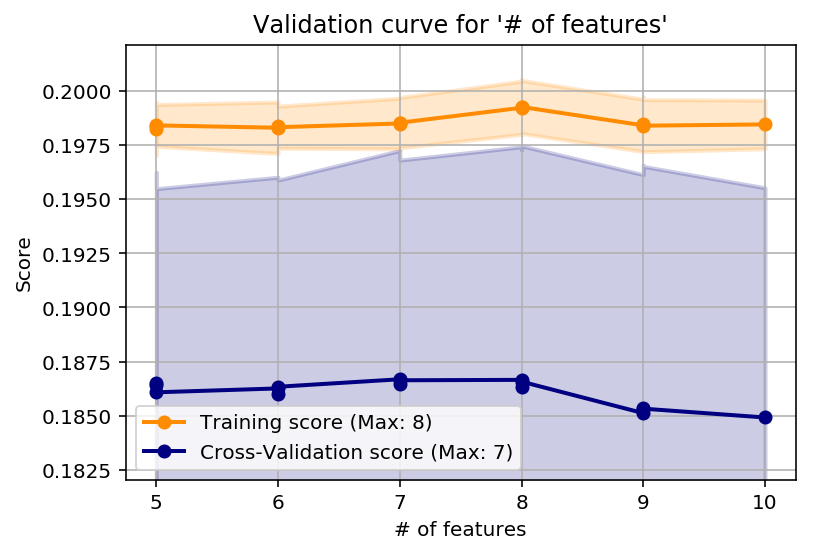

In [29]:
train_scores = pd.DataFrame(train_scores)
test_scores = pd.DataFrame(test_scores)

train_scores.name = 'Training score'
test_scores.name = 'Cross-Validation score'

plot_validation_curve(param_range, train_scores, test_scores)

##### Hidden neurons

In [30]:
param_range = pd.Series(np.geomspace(64, 8192, num=16, dtype=int), name='# of hidden neurons')

train_scores, test_scores = validation_curve(
    models['elm'], 
    X, 
    y, 
    param_name='rl__n_hidden', 
    param_range=param_range,
    cv=cv, 
    scoring='r2'
)

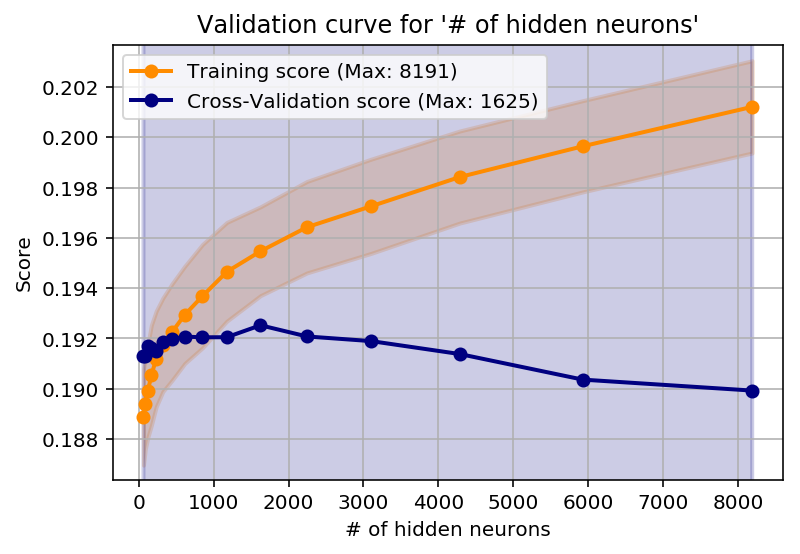

In [31]:
train_scores = pd.DataFrame(train_scores)
test_scores = pd.DataFrame(test_scores)

train_scores.name = 'Training score'
test_scores.name = 'Cross-Validation score'

plot_validation_curve(param_range, train_scores, test_scores)

#### SVM

##### Number of features

In [32]:
param_range = pd.Series(np.linspace(5, len(feature_scores), num=16, dtype=int), name='# of features')

train_scores, test_scores = validation_curve(
    models['svm'], 
    X, 
    y, 
    param_name='selector__k', 
    param_range=param_range,
    cv=cv, 
    scoring='r2'
)

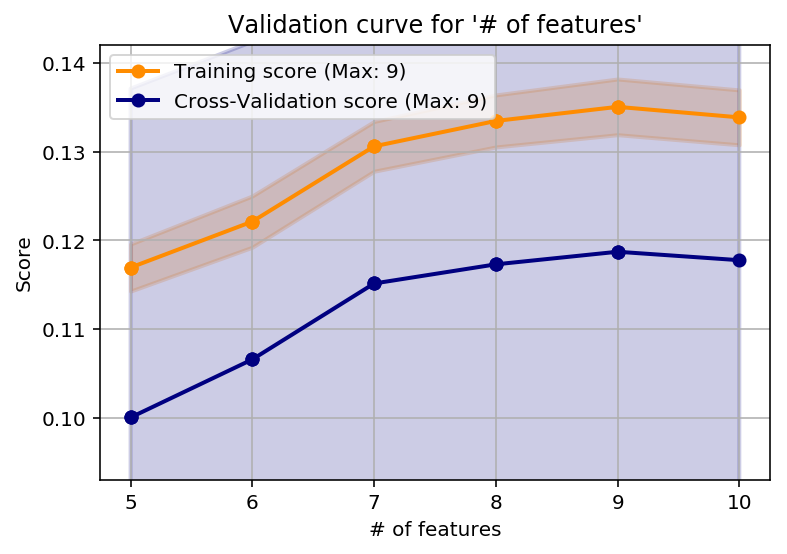

In [33]:
train_scores = pd.DataFrame(train_scores)
test_scores = pd.DataFrame(test_scores)

train_scores.name = 'Training score'
test_scores.name = 'Cross-Validation score'

plot_validation_curve(param_range, train_scores, test_scores)

##### C

In [34]:
param_range = pd.Series(np.geomspace(1e-4, 100, num=16), name='C')

train_scores, test_scores = validation_curve(
    models['svm'], 
    X, 
    y, 
    param_name='svm__C', 
    param_range=param_range,
    cv=cv, 
    scoring='r2'
)

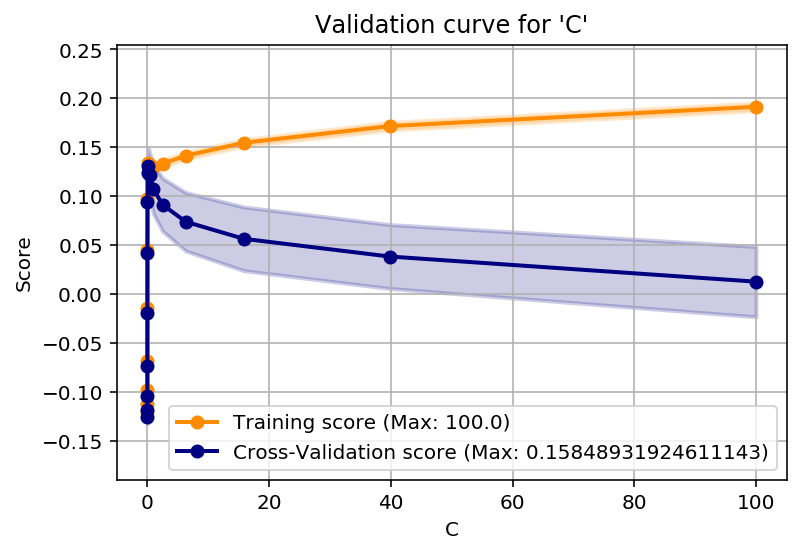

In [35]:
train_scores = pd.DataFrame(train_scores)
test_scores = pd.DataFrame(test_scores)

train_scores.name = 'Training score'
test_scores.name = 'Cross-Validation score'

plot_validation_curve(param_range, train_scores, test_scores)

### Learning curve

In [36]:
from sklearn.model_selection import learning_curve

#### ELM

In [37]:
train_sizes, train_scores, test_scores = learning_curve(
    models['elm'], 
    X, 
    y, 
    train_sizes=np.linspace(.1, 1.0, num=16),
    cv=cv,
    scoring='r2',
    shuffle=True
)

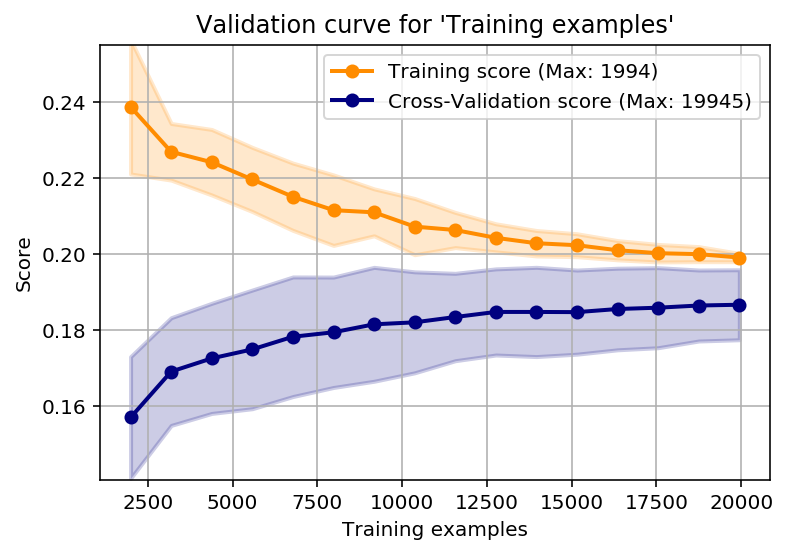

In [38]:
train_sizes = pd.Series(train_sizes, name='Training examples')
train_scores = pd.DataFrame(train_scores)
test_scores = pd.DataFrame(test_scores)

train_scores.name = 'Training score'
test_scores.name = 'Cross-Validation score'

plot_validation_curve(train_sizes, train_scores, test_scores)

#### SVM

In [39]:
train_sizes, train_scores, test_scores = learning_curve(
    models['svm'], 
    X, 
    y, 
    train_sizes=np.linspace(.1, 1.0, num=16),
    cv=cv,
    scoring='r2',
    shuffle=True
)

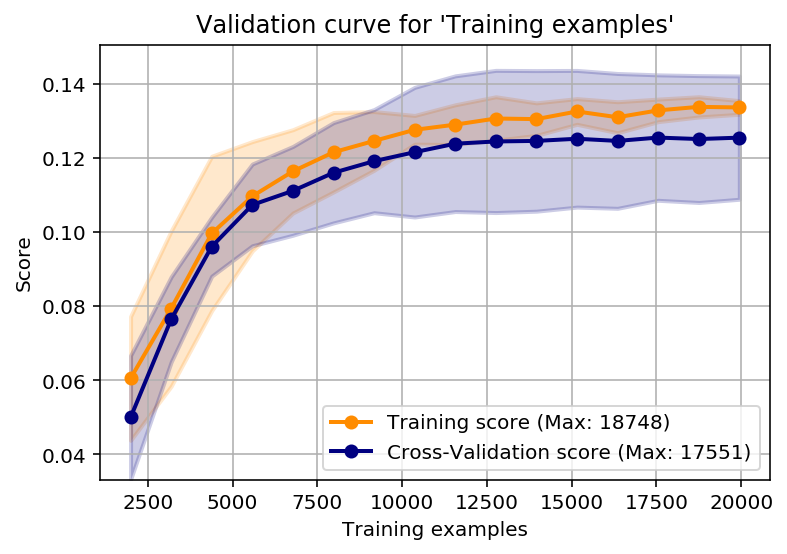

In [40]:
train_sizes = pd.Series(train_sizes, name='Training examples')
train_scores = pd.DataFrame(train_scores)
test_scores = pd.DataFrame(test_scores)

train_scores.name = 'Training score'
test_scores.name = 'Cross-Validation score'

plot_validation_curve(train_sizes, train_scores, test_scores)

## Validations

In [41]:
from sklearn.base import clone

### ELM

In [42]:
model = clone(models['elm'])
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_test), index=y_test.index, name='{} prediction'.format(y_test.name))

get_scores([
    pd.Series([y_train, model.predict(X_train)], name='Training'),
    pd.Series([y_test, y_pred], name='Testing'),
])

,EV,R2,RMSE
Training,0.198735,0.198735,9.261289
Testing,0.189418,0.189413,9.336509


#### Histogram compare

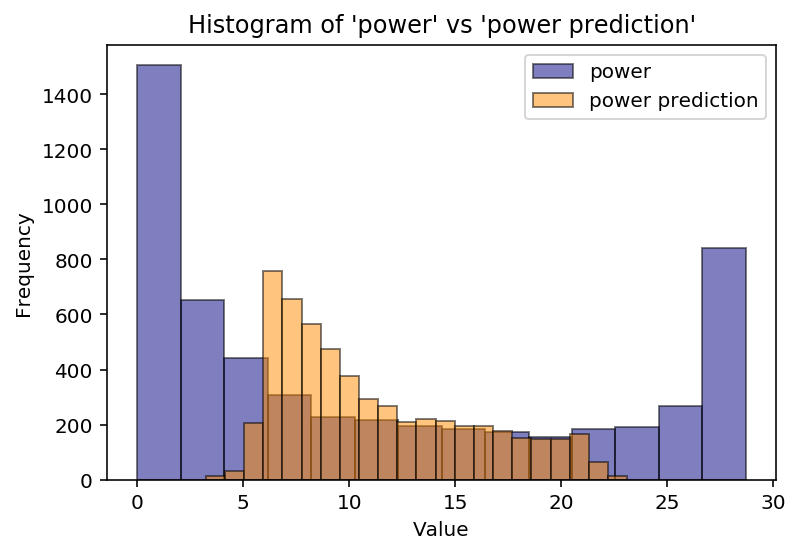

In [43]:
plot_histogram_compare(y_test, y_pred)

#### Scatter compare

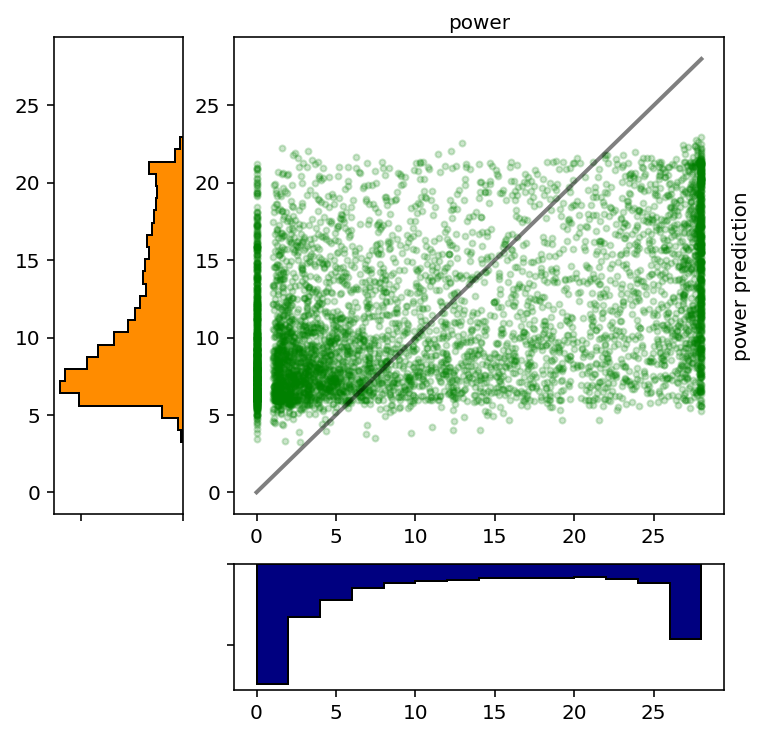

In [44]:
plot_scatter_histogram(y_test, y_pred)

#### Accuracy histogram

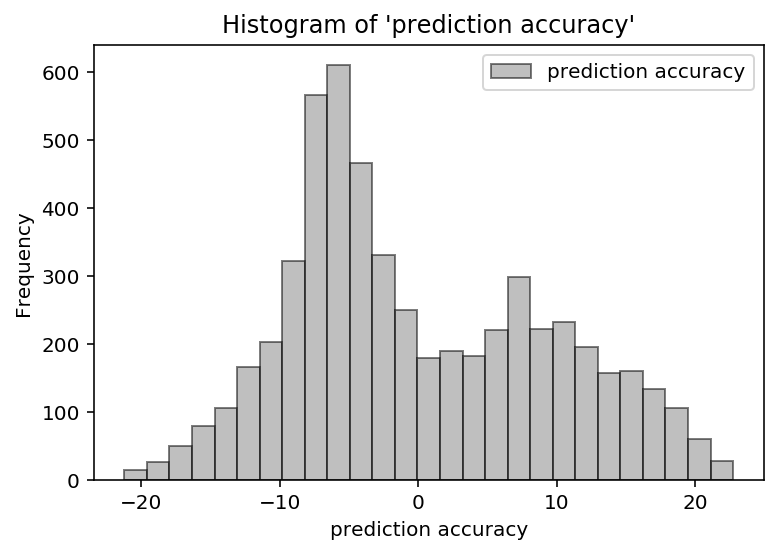

In [45]:
y_accuracy = pd.Series(y_test - y_pred, name='prediction accuracy')

plot_histogram(y_accuracy)

### SVM

In [46]:
model = clone(models['svm'])
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_test), index=y_test.index, name='{} prediction'.format(y_test.name))

get_scores([
    pd.Series([y_train, model.predict(X_train)], name='Training'),
    pd.Series([y_test, y_pred], name='Testing'),
])

,EV,R2,RMSE
Training,0.164032,0.131020,9.644693
Testing,0.163819,0.129532,9.675228


#### Histogram compare

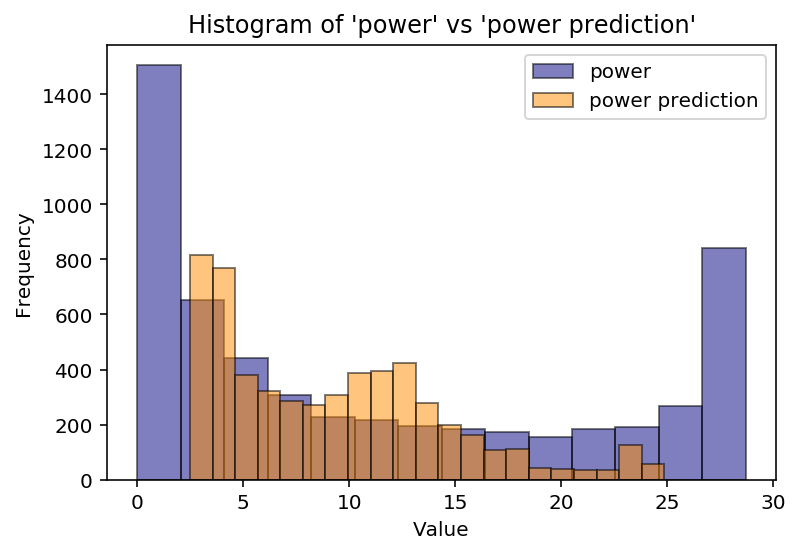

In [47]:
plot_histogram_compare(y_test, y_pred)

#### Scatter compare

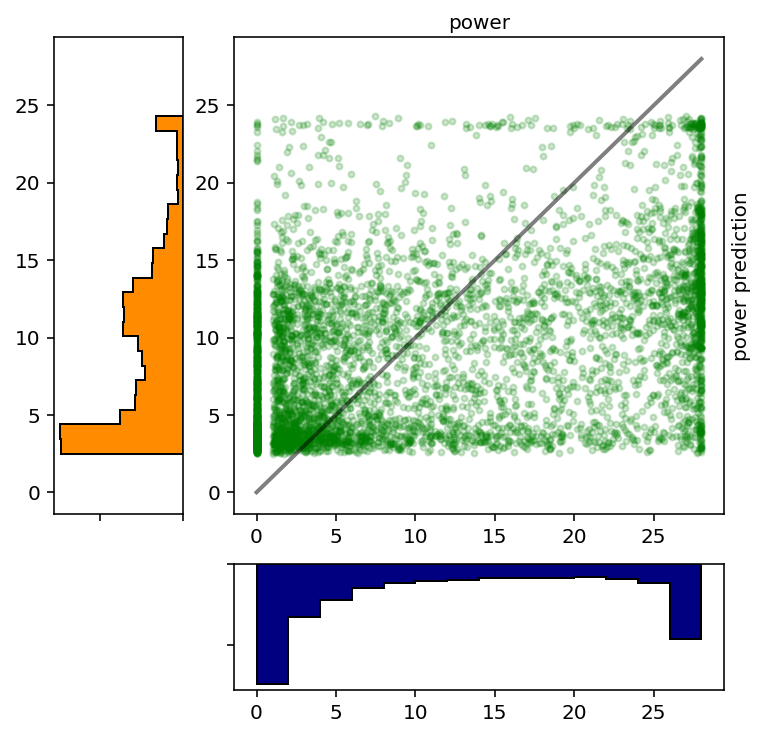

In [48]:
plot_scatter_histogram(y_test, y_pred)

#### Accuracy histogram

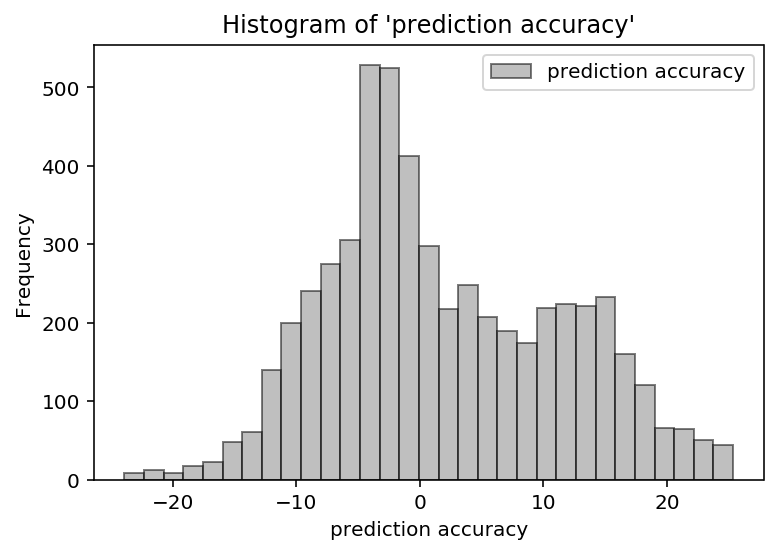

In [49]:
y_accuracy = pd.Series(y_test - y_pred, name='prediction accuracy')

plot_histogram(y_accuracy)